___
# Trabalho Prático – Exploração e Mapeamento
**Estudante: Nathan Augusto Zacarias Xavier**

# Introdução

A implementação de técnicas de exploração e mapeamento são extremamente importantes durante a utilização de robôs em ambientes desconhecidos. 

O objetivo deste trabalho prático é ter um contato com as ferramentas de simulação e programação. O software de simulação é o CoppeliaSim, enquanto a linguagem de programação indicada foi a Python, desenvolvido via Jupyter Notebook.

Para iniciar tal desenvolvimento, foram construídos dois mapas diferentes a serem apresentados. Cada mapa possui obstáculos e formatos diferentes, para analisar a aplicação da exploração em cenários distintos.

## Mapas de Simulação

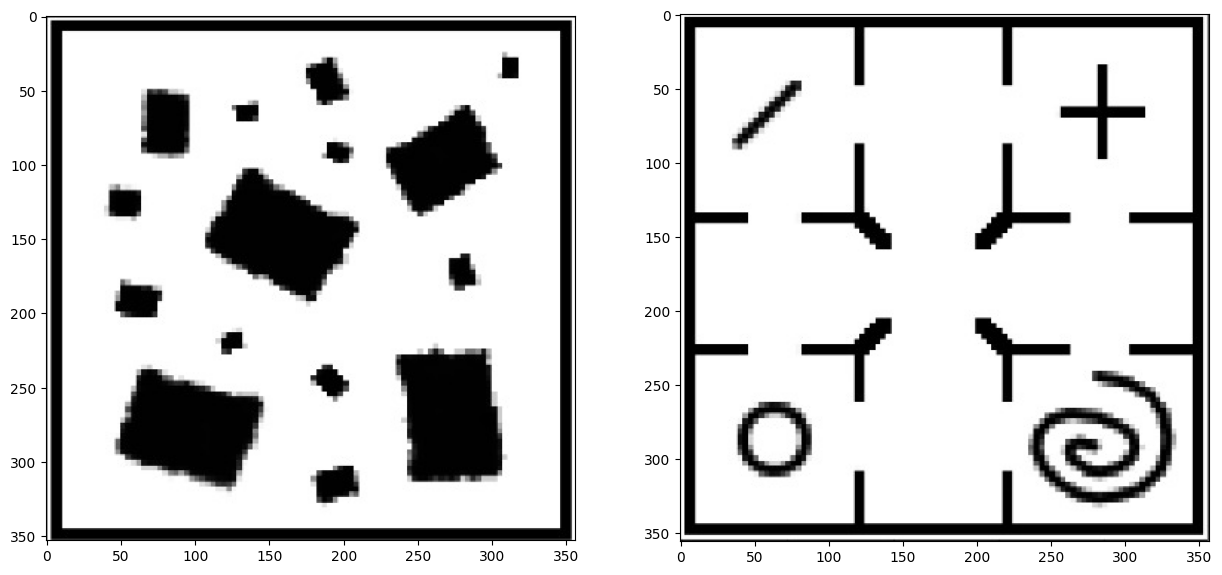

In [1]:
# Bibliotecas de Interesse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import seaborn as sns
import imageio
import math
import networkx as nx
import time
from scipy.interpolate import interp1d
from skimage.draw import line

# Importação do Mapa
fig = plt.figure(figsize=(15,8), dpi=100)
ax0 = fig.add_subplot(121)
img0 = mpimg.imread('mapa0.png')
ax0.imshow(img0, cmap='Greys', origin='upper');

ax1 = fig.add_subplot(122)
img1 = mpimg.imread('mapa1.png')
ax1.imshow(img1, cmap='Greys', origin='upper');

# Dimensões do mapa 1 em metros (X, Y)
mapCoppelia0 = 20
map_dims = mapCoppelia0*np.array([50,50])
sy, sx = img0.shape[:2] / map_dims

# Tamanho da célula do Grid
cell_size0 = mapCoppelia0/2
rMC0 = (map_dims/cell_size0)/mapCoppelia0 # Ajuste Mapa->Coppelia
rows0, cols0 = (map_dims / cell_size0).astype(int)

Como pode-se observar, o primeiro mapa representa um campo com um grande número de obstáculos de diferentes tamanhos e formatos. A disposição destes foi feita de modo que o robô, praticamente em todas as localizações, detecta-se algum obstáculo através do sensor de laser.

O segundo mapa, entretanto, foi construído de forma similar a um corredor e salas com obstáculos de diferentes formatos. Espera-se que o robô seja capaz de observar o conteúdo que é colocado dentro de cada sala durante a navegação.

## Análise do Sensor

Antes da implementação da exploração, faz-se necessário a apresentação do sensor utilizado, além do erro introduzido no mesmo.

Connected to remote API server


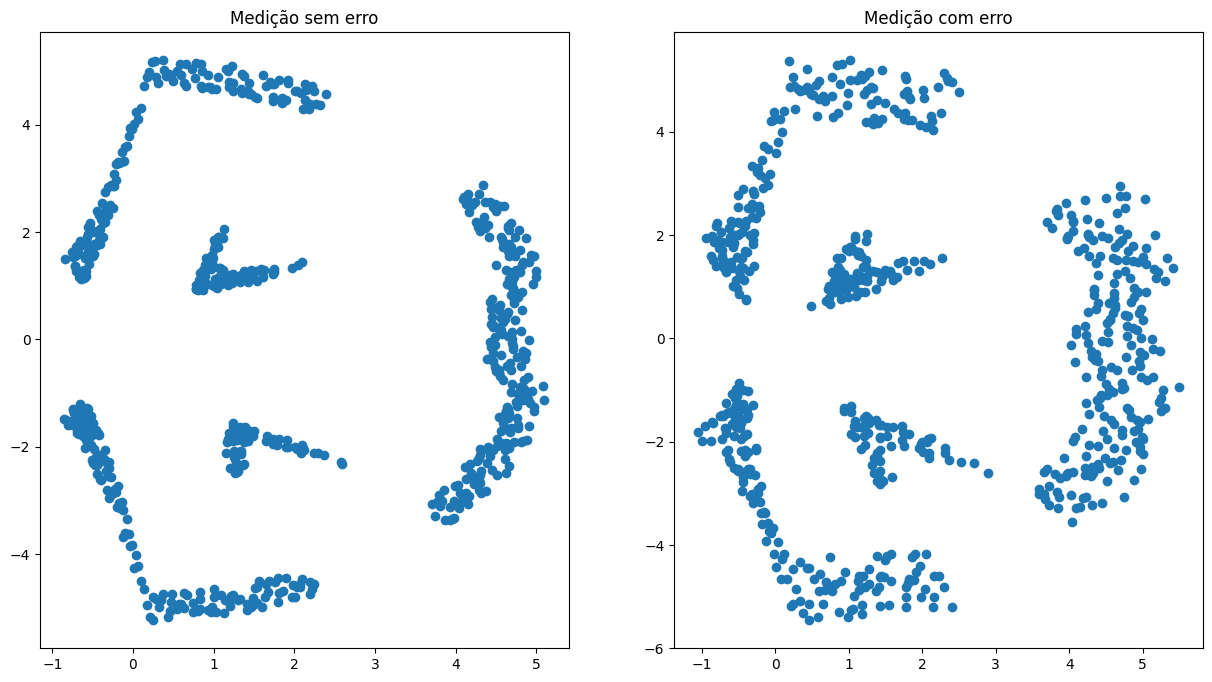

In [16]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod(angle+np.pi, 2*np.pi) - np.pi

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1):
    print ('Connected to remote API server')
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)

    # Descarta 1ª medição
    returnCode, ranges = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_streaming)
    time.sleep(0.1)
    
    # Get valid data
    returnCode, ranges = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_buffer)
    sensRange = sim.simxUnpackFloats(ranges)
    
    angleMin = (-120*(math.pi/180)),
    angleMax = (120*(math.pi/180)),
    dAngle = (240*math.pi)/(684*180),
    sensAngle = np.linspace(angleMin, angleMax, 684)
    
    x = []; y = []
    xe = []; ye = []
    for angle, dist in zip(sensAngle, sensRange):
        #print(angle, dist)
        erro = random.random()-0.5 # Introdução do Ruído
        #dist += erro
        dist = dist +0.5*(random.random()-0.5) # Introdução do Ruído
        globalAngle = normalizeAngle(roboOri[2] +angle)
        x.append(dist*math.cos(globalAngle))
        y.append(dist*math.sin(globalAngle))
        
        xe.append((dist+erro)*math.cos(globalAngle))
        ye.append((dist+erro)*math.sin(globalAngle))
            
    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)

fig = plt.figure(figsize=(15,8), dpi=100)
ax0 = fig.add_subplot(121)
ax0.scatter(x, y);
ax0.set_title("Medição sem erro");
ax1 = fig.add_subplot(122)
ax1.scatter(xe, ye);
ax1.set_title("Medição com erro");

Como pode-se observar, o erro implementado é, somente, aleatório, de modo que as leituras aparecem mais espaçadas, buscando uma similaridade maior com sensores reais.

___
# Exploração

## Mapa 01

In [3]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

def Rz(theta):
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])
# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod(angle+np.pi, 2*np.pi) - np.pi

rMC = rMC0
cell_size = cell_size0
rows = rows0
cols = cols0
img = img0

sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1):
    print ('Connected to remote API server')
    
    # Características do Robô
    L = 0.331
    r = 0.09751
    maxv = 1.0
    maxw = np.deg2rad(45)
    
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)
    
    # Características Sensor Hokuyo
    laserMax = 5.0
    angleMin = (-120*(math.pi/180))
    angleMax = (120*(math.pi/180))
    dAngle = (240*math.pi)/(684*180)
    sensAngle = np.linspace(angleMin, angleMax, 684)
    
    # Descarta 1ª medição
    returnCode, ranges = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_streaming)
    time.sleep(0.1)
    
    # Frame Goal
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    
    # Mapa 
    mapa = 0.5*np.ones((rows, cols))
    mapaRobo = np.array([round((roboPos[0]+cell_size)*rMC[1]), abs(round((roboPos[1]-cell_size)*rMC[0]))])
    mapa[mapaRobo[1], mapaRobo[0]] = 0
    
    qGoal = np.array([roboPos[0], roboPos[1]])
    x = []; y = []
    mapaRobox = []; mapaRoboy = []
    startTime = int(time.strftime("%M"))
    fTempo = 0
    f_Obst = 0
    
    kr = .5
    kt = 2
    goal = 3
    
    novoPerc = 1
    tamPerc = posPerc = np.inf
    
    while fTempo == 0:
        # Leitura dos Sensores
        returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
        returnCode, roboHokuyo = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_buffer)
        sensRange = sim.simxUnpackFloats(roboHokuyo)
        
        mapaRobo = np.array([round((roboPos[0]+cell_size)*rMC[1]), abs(round((roboPos[1]-cell_size)*rMC[0]))])
        mapaRobox.append([mapaRobo[0]])
        mapaRoboy.append([mapaRobo[1]])
        
        # Atualização do Mapa
        atualiza = np.ones((rows, cols))
        xMapaMin = np.inf; xMapaMax = -1
        yMapaMin = np.inf; yMapaMax = -1
        
        # Leituras do Hokuyo
        for angle, dist in zip(sensAngle, sensRange):
            erro = random.random()-0.5 # Introdução do Ruído
            dist += erro
            globalAngle = normalizeAngle(roboOri[2] +angle)
            
            # Transformação Coppelia -> Mapa
            xs = (dist*rMC[0])*math.cos(globalAngle) +mapaRobo[0]
            ys = -(dist*rMC[1])*math.sin(globalAngle) +mapaRobo[1] # Rows Invertido
            
            # Campo de Visão
            c0 = np.floor(mapaRobo[0]).astype(int)
            r0 = np.floor(mapaRobo[1]).astype(int)
            c1 = np.floor(xs).astype(int)
            r1 = np.floor(ys).astype(int)
            xMapa, yMapa = line(r0, c0, r1, c1)
            
            # Probabilidades do Sensor
            fFinal = 0
            for i, j in zip(xMapa[::-1], yMapa[::-1]):
                if((i>0 and i<rows) and (j>0 and j<cols)):
                    if(fFinal<3 and dist<5):
                        atualiza[i-2:i,j-2:j] += 1-dist/laserMax # Grid de leitura  = distância medida
                        fFinal += 1
                    else:
                        atualiza[i, j] -= 0.05
                    
                    # Região de Mudanças do Sensor
                    xMapaMin = min(xMapaMin, i)
                    xMapaMax = max(xMapaMax, i)
                    yMapaMin = min(yMapaMin, j)
                    yMapaMax = max(yMapaMax, j)
        
        # Atualização das Probabilidades
        for i in np.arange(xMapaMin, xMapaMax):
            for j in np.arange(yMapaMin, yMapaMax):
                mapa[i,j] = mapa[i,j]*atualiza[i,j] # Não observado = 1; Livre<1; Espaço Ocupado>1
                mapa[i,j] = max(min(mapa[i,j], 1), 0.001) # Limite de Probabilidade
        
        # Criação de Caminho
        if(novoPerc == 1): # Novo Percurso
            rPos, cPos = np.where(mapa==0.5)
            rTrack, cTrack = random.choice(list(zip(rPos, cPos)))
            # Caminho Criado
            xPerc, yPerc = line(r0, c0, rTrack, cTrack)
            posPerc = 1
            tamPerc = len(list(zip(xPerc, yPerc)))
            novoPerc = 0
        
        # Trajetória
        if(posPerc<tamPerc):
            try:
                if(np.all(mapa[xPerc[posPerc:posPerc+5], yPerc[posPerc:posPerc+5]] < .3)): # Próximas Posições são Válidas
                    if(posPerc==1 or rho<0.5): # Atualização do Goal
                        qGoal = np.array(list(zip(xPerc, yPerc)))[posPerc]
                        # Transformação Ref.Mapa -> Ref.Coppelia
                        qGoal = [(qGoal[1]/rMC[0])-cell_size, -((qGoal[0]/rMC[1])-cell_size)]
                        posPerc+=1 # Alvo Próxima Posição
                else:
                    novoPerc = 1
                    qGoal = np.array([roboPos[0], roboPos[1]])
            except: # Evita aproximar de Obstáculo
                novoPerc = 1
                qGoal = np.array([roboPos[0], roboPos[1]])
        else:
            novoPerc = 1
        returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [qGoal[0], qGoal[1], .5], sim.simx_opmode_oneshot_wait)
        
        # Movimento
        dx = qGoal[0] -roboPos[0]
        dy = qGoal[1] -roboPos[1]
        rho = np.sqrt(dx**2 +dy**2)
        kr = abs(kr)
        alpha = normalizeAngle(-roboOri[2] + np.arctan2(dy,dx))
        
        # Alvo atrás
        if abs(alpha) > np.pi/2:
            kr = -abs(kr)
            alpha = normalizeAngle(alpha-np.pi)
        
        v = kr*rho
        w = kt*alpha
        
        # Limit v,w to +/- max
        v = max(min(v, maxv), -maxv)
        w = max(min(w, maxw), -maxw)
        
        wr = ((2.0*v) + (w*L))/(2.0*r)
        wl = ((2.0*v) - (w*L))/(2.0*r)

        sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, wr, sim.simx_opmode_oneshot_wait)
        sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, wl, sim.simx_opmode_oneshot_wait)
        
        nowTime = int(time.strftime("%M"))
        if int(nowTime) == (int(startTime) +3)%59:
            fTempo = 1
    
    sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho Realizado
    fig = plt.figure(figsize=(15,15), dpi=100)
    ax0 = fig.add_subplot(121, aspect='equal')
    ax0.imshow(mapa, cmap="Greys")
    ax0.set_title("Exploração do Robô");

    ax1 = fig.add_subplot(122, aspect='equal')
    ax1.imshow(mapa, extent=(0, rows, 0, cols), cmap="Greys")
    ax1.imshow(img, cmap='Greys', extent=(0, rows, 0, cols), alpha=0.5)
    ax1.set_title("Exploração sobreposta ao mapa simulado");

Connected to remote API server


ValueError: Maximum allowed size exceeded

Os resultados obtidos nas imagens anteriores demonstram o bom resultado da técnica na exploração do ambiente desconhecido.

Na implementação, o robô se movo sempre para posições desconhecidas do mapa e altera o alvo quando encontra qualquer obstáculo ou uma posição desconhecida com que o sensor não tenha observado anteriormente. Esta última situação é observada quando o robô passa a se locomover para trás. Optou-se por tal solução devido ao amplo campo de visão do sensor, além de isso não gerar grandes impactos na navegação.

No resultado obtido, grande parte dos obstáculos foram corretamente detectados. Somente poucos obstáculos menores e próximos do robô não foram corretamente indicados.

![title](Sim1_Mapa0.png)

___
## Mapa 02

Visto que o robô é capaz de se locomover em um ambiente desconhecido, a utilização do segundo mapa tem como proposta apresentar como o grid do mapa impacta no resultado final. Desta forma, serão desenvolvidas duas simulações no segundo mapa apresentado, mas com a diferença no tamanho dos grids do mapa que será desenvolvido pela visão do sensor.

A divisão dos grids é apresentada a seguir.

In [20]:
# Dimensões do mapa 2 em metros (X, Y)
mapCoppelia1 = 15
map_dims = mapCoppelia1*np.array([50,50])
sy, sx = img1.shape[:2] / map_dims

cell_size1 = mapCoppelia1/2
rMC1 = (map_dims/cell_size1)/mapCoppelia1 # Ajuste Mapa->Coppelia
rows1, cols1 = (map_dims / cell_size1).astype(int)

cell_size2 = mapCoppelia1/5
rMC2 = (map_dims/cell_size2)/mapCoppelia1 # Ajuste Mapa->Coppelia
rows2, cols2 = (map_dims / cell_size2).astype(int)

grid1 = np.zeros((rows1, cols1))
grid2 = np.zeros((rows2, cols2))

# Preenchendo o Grid
for r in range(rows1):
    for c in range(cols1):
        xi = int(c*cell_size1*sx)
        xf = int(xi + cell_size1*sx)
        yi = int(r*cell_size1*sy)
        yf = int(yi + cell_size1*sy)
        grid1[r, c] = np.sum(img1[yi:yf,xi:xf])

for r in range(rows2):
    for c in range(cols2):
        xi = int(c*cell_size2*sx)
        xf = int(xi + cell_size2*sx)
        yi = int(r*cell_size2*sy)
        yf = int(yi + cell_size2*sy)
        grid2[r, c] = np.sum(img1[yi:yf,xi:xf])

threshold = 0.5
grid1[grid1 > threshold] = 1
grid1[grid1<= threshold] = 0
grid2[grid2 > threshold] = 1
grid2[grid2<= threshold] = 0

fig = plt.figure(figsize=(15,8), dpi=100)
ax0 = fig.add_subplot(121)
img0 = mpimg.imread('mapa1.png')
obj = ax0.imshow(img1, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax0.imshow(grid1, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)
ax0.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1);
ax0.set_xticks(np.arange(0, map_dims[1]+1, cell_size1));
ax0.set_yticks(np.arange(0, map_dims[0]+1, cell_size1));

ax1 = fig.add_subplot(122)
img1 = mpimg.imread('mapa1.png')
obj = ax1.imshow(img1, cmap='Greys', extent=(0, map_dims[1], 0, map_dims[0]), origin='upper')
obj = ax1.imshow(grid2, cmap='Reds', extent=(0, map_dims[1], 0, map_dims[0]), alpha=.6)
ax1.grid(which='major', axis='both', linestyle='-', color='r', linewidth=1);
ax1.set_xticks(np.arange(0, map_dims[1]+1, cell_size2));
ax1.set_yticks(np.arange(0, map_dims[0]+1, cell_size2));


KeyboardInterrupt



___
### Simulação 01

In [2]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

def Rz(theta):
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])
# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod(angle+np.pi, 2*np.pi) - np.pi

rMC = rMC1
cell_size = cell_size1
rows = rows1
cols = cols1
img = img1
                
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1):
    print ('Connected to remote API server')
    
    # Características do Robô
    L = 0.331
    r = 0.09751
    maxv = 1.0
    maxw = np.deg2rad(45)
    
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)
    
    # Características Sensor Hokuyo
    laserMax = 5.0
    angleMin = (-120*(math.pi/180))
    angleMax = (120*(math.pi/180))
    dAngle = (240*math.pi)/(684*180)
    sensAngle = np.linspace(angleMin, angleMax, 684)
    
    # Descarta 1ª medição
    returnCode, ranges = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_streaming)
    time.sleep(0.1)
    
    # Frame Goal
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    
    # Mapa 
    mapa = 0.5*np.ones((rows, cols))
    mapaRobo = np.array([round((roboPos[0]+cell_size)*rMC[1]), abs(round((roboPos[1]-cell_size)*rMC[0]))])
    mapa[mapaRobo[1], mapaRobo[0]] = 0
    
    qGoal = np.array([roboPos[0], roboPos[1]])
    x = []; y = []
    mapaRobox = []; mapaRoboy = []
    startTime = int(time.strftime("%M"))
    f_Obst = 0
    
    kr = .3
    kt = 1
    goal = 3
    
    # Criação do Percurso
    path = []
    path.append([0,0])
    path.append([0,-5])
    path.append([0,0])
    path.append([5,0])
    path.append([0,0])
    path.append([0,5])
    path.append([0,0])
    
    for posPath in path:
        # Transformação Ref.Mapa -> Ref.Coppelia
        qGoal = np.array([posPath[0], posPath[1]])
        
        returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [qGoal[0], qGoal[1], .5], sim.simx_opmode_oneshot_wait)
        
        rho = np.inf
                          
        while rho>0.5:
            # Leitura dos Sensores
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            returnCode, roboHokuyo = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_buffer)
            sensRange = sim.simxUnpackFloats(roboHokuyo)

            mapaRobo = np.array([round((roboPos[0]+cell_size)*rMC[1]), abs(round((roboPos[1]-cell_size)*rMC[0]))])
            mapaRobox.append([mapaRobo[0]])
            mapaRoboy.append([mapaRobo[1]])

            # Atualização do Mapa
            atualiza = np.ones((rows, cols))
            xMapaMin = np.inf; xMapaMax = -1
            yMapaMin = np.inf; yMapaMax = -1

            # Leituras do Hokuyo
            for angle, dist in zip(sensAngle, sensRange):
                erro = random.random()-0.5 # Introdução do Ruído
                dist += erro
                globalAngle = normalizeAngle(roboOri[2] +angle)

                # Transformação Coppelia -> Mapa
                xs = (dist*rMC[0])*math.cos(globalAngle) +mapaRobo[0]
                ys = -(dist*rMC[1])*math.sin(globalAngle) +mapaRobo[1] # Rows Invertido

                # Campo de Visão
                c0 = np.floor(mapaRobo[0]).astype(int)
                r0 = np.floor(mapaRobo[1]).astype(int)
                c1 = np.floor(xs).astype(int)
                r1 = np.floor(ys).astype(int)
                xMapa, yMapa = line(r0, c0, r1, c1)

                # Probabilidades do Sensor
                fFinal = 0
                for i, j in zip(xMapa[::-1], yMapa[::-1]):
                    if((i>0 and i<rows) and (j>0 and j<cols)):
                        if(fFinal<1 and dist<5):
                            atualiza[i-2:i,j-2:j] += 1-dist/laserMax # Grid de leitura  = distância medida
                            fFinal += 1
                        else:
                            atualiza[i, j] -= 0.05

                        # Região de Mudanças do Sensor
                        xMapaMin = min(xMapaMin, i)
                        xMapaMax = max(xMapaMax, i)
                        yMapaMin = min(yMapaMin, j)
                        yMapaMax = max(yMapaMax, j)

            # Atualização das Probabilidades
            for i in np.arange(xMapaMin, xMapaMax):
                for j in np.arange(yMapaMin, yMapaMax):
                    mapa[i,j] = mapa[i,j]*atualiza[i,j] # Não observado = 1; Livre<1; Espaço Ocupado>1
                    mapa[i,j] = max(min(mapa[i,j], 1), 0.001) # Limite de Probabilidade


            # Movimento
            dx = qGoal[0] -roboPos[0]
            dy = qGoal[1] -roboPos[1]
            rho = np.sqrt(dx**2 +dy**2)
            kr = 0.3
            alpha = normalizeAngle(-roboOri[2] + np.arctan2(dy,dx))

            if abs(alpha) > np.pi/6:
                kr = 0.01
            
            v = kr*rho
            w = kt*alpha

            # Limit v,w to +/- max
            v = max(min(v, maxv), -maxv)
            w = max(min(w, maxw), -maxw)

            wr = ((2.0*v) + (w*L))/(2.0*r)
            wl = ((2.0*v) - (w*L))/(2.0*r)

            sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, wr, sim.simx_opmode_oneshot_wait)
            sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, wl, sim.simx_opmode_oneshot_wait)

    sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho Realizado
    fig = plt.figure(figsize=(15,15), dpi=100)
    ax0 = fig.add_subplot(121, aspect='equal')
    ax0.imshow(mapa, cmap="Greys")
    ax0.set_title("Exploração do Robô");

    ax1 = fig.add_subplot(122, aspect='equal')
    ax1.imshow(mapa, extent=(0, rows, 0, cols), cmap="Greys")
    ax1.imshow(img, cmap='Greys', extent=(0, rows, 0, cols), alpha=0.5)
    ax1.set_title("Exploração sobreposta ao mapa simulado");

NameError: name 'rMC1' is not defined

Os resultados obtidos foram igualmente bons, de modo que o robô consegue identificar grande parte dos obstáculos com clareza, apesar do erro do sensor, que, muitas vezes, gera regiões grandes de incerteza sobre a posição do obstáculo.

![title](Sim2_Mapa1.png)

___
### Simulação 02

In [17]:
try:
    import sim
except:
    print ('"sim.py" could not be imported.')

def Rz(theta):
    return np.array([[ np.cos(theta), -np.sin(theta), 0 ],
                      [ np.sin(theta), np.cos(theta) , 0 ],
                      [ 0            , 0             , 1 ]])
# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod(angle+np.pi, 2*np.pi) - np.pi

rMC = rMC2
cell_size = cell_size1
rows = rows2
cols = cols2
img = img1
                
sim.simxFinish(-1) # just in case, close all opened connections
clientID=sim.simxStart('127.0.0.1',19999,True,True,5000,5) # Connect to CoppeliaSim

if (clientID!=-1):
    print ('Connected to remote API server')
    
    # Características do Robô
    L = 0.331
    r = 0.09751
    maxv = 1.0
    maxw = np.deg2rad(45)
    
    robotname = 'Pioneer_p3dx'
    returnCode, robotHandle = sim.simxGetObjectHandle(clientID, robotname, sim.simx_opmode_oneshot_wait)
    returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
    returnCode, robotLeftMotorHandle  = sim.simxGetObjectHandle(clientID, robotname + '_leftMotor', sim.simx_opmode_oneshot_wait)
    returnCode, robotRightMotorHandle = sim.simxGetObjectHandle(clientID, robotname + '_rightMotor', sim.simx_opmode_oneshot_wait)
    
    # Características Sensor Hokuyo
    laserMax = 5.0
    angleMin = (-120*(math.pi/180))
    angleMax = (120*(math.pi/180))
    dAngle = (240*math.pi)/(684*180)
    sensAngle = np.linspace(angleMin, angleMax, 684)
    
    # Descarta 1ª medição
    returnCode, ranges = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_streaming)
    time.sleep(0.1)
    
    # Frame Goal
    returnCode, goalFrame = sim.simxGetObjectHandle(clientID, 'Goal', sim.simx_opmode_oneshot_wait)
    
    # Mapa 
    mapa = 0.5*np.ones((rows, cols))
    mapaRobo = np.array([round((roboPos[0]+cell_size)*rMC[1]), abs(round((roboPos[1]-cell_size)*rMC[0]))])
    mapa[mapaRobo[1], mapaRobo[0]] = 0
    
    qGoal = np.array([roboPos[0], roboPos[1]])
    x = []; y = []
    mapaRobox = []; mapaRoboy = []
    startTime = int(time.strftime("%M"))
    f_Obst = 0
    
    kr = .3
    kt = 1
    goal = 3
    
    # Criação do Percurso
    path = []
    path.append([0,0])
    path.append([0,-5])
    path.append([0,0])
    path.append([5,0])
    path.append([0,0])
    path.append([0,5])
    path.append([0,0])
    
    for posPath in path:
        # Transformação Ref.Mapa -> Ref.Coppelia
        qGoal = np.array([posPath[0], posPath[1]])
        
        returnCode = sim.simxSetObjectPosition(clientID, goalFrame, -1, [qGoal[0], qGoal[1], .5], sim.simx_opmode_oneshot_wait)
        
        rho = np.inf
                          
        while rho>0.5:
            # Leitura dos Sensores
            returnCode, roboPos = sim.simxGetObjectPosition(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            returnCode, roboOri = sim.simxGetObjectOrientation(clientID, robotHandle, -1, sim.simx_opmode_oneshot_wait)
            returnCode, roboHokuyo = sim.simxGetStringSignal(clientID, 'scan ranges', sim.simx_opmode_buffer)
            sensRange = sim.simxUnpackFloats(roboHokuyo)

            mapaRobo = np.array([round((roboPos[0]+cell_size)*rMC[1]), abs(round((roboPos[1]-cell_size)*rMC[0]))])
            mapaRobox.append([mapaRobo[0]])
            mapaRoboy.append([mapaRobo[1]])

            # Atualização do Mapa
            atualiza = np.ones((rows, cols))
            xMapaMin = np.inf; xMapaMax = -1
            yMapaMin = np.inf; yMapaMax = -1

            # Leituras do Hokuyo
            for angle, dist in zip(sensAngle, sensRange):
                erro = random.random()-0.5 # Introdução do Ruído
                dist += erro
                globalAngle = normalizeAngle(roboOri[2] +angle)

                # Transformação Coppelia -> Mapa
                xs = (dist*rMC[0])*math.cos(globalAngle) +mapaRobo[0]
                ys = -(dist*rMC[1])*math.sin(globalAngle) +mapaRobo[1] # Rows Invertido

                # Campo de Visão
                c0 = np.floor(mapaRobo[0]).astype(int)
                r0 = np.floor(mapaRobo[1]).astype(int)
                c1 = np.floor(xs).astype(int)
                r1 = np.floor(ys).astype(int)
                xMapa, yMapa = line(r0, c0, r1, c1)

                # Probabilidades do Sensor
                fFinal = 0
                for i, j in zip(xMapa[::-1], yMapa[::-1]):
                    if((i>0 and i<rows) and (j>0 and j<cols)):
                        if(fFinal<1 and dist<5):
                            atualiza[i-2:i,j-2:j] += 1-dist/laserMax # Grid de leitura  = distância medida
                            fFinal += 1
                        else:
                            atualiza[i, j] -= 0.05

                        # Região de Mudanças do Sensor
                        xMapaMin = min(xMapaMin, i)
                        xMapaMax = max(xMapaMax, i)
                        yMapaMin = min(yMapaMin, j)
                        yMapaMax = max(yMapaMax, j)

            # Atualização das Probabilidades
            for i in np.arange(xMapaMin, xMapaMax):
                for j in np.arange(yMapaMin, yMapaMax):
                    mapa[i,j] = mapa[i,j]*atualiza[i,j] # Não observado = 1; Livre<1; Espaço Ocupado>1
                    mapa[i,j] = max(min(mapa[i,j], 1), 0.001) # Limite de Probabilidade


            # Movimento
            dx = qGoal[0] -roboPos[0]
            dy = qGoal[1] -roboPos[1]
            rho = np.sqrt(dx**2 +dy**2)
            kr = 0.3
            alpha = normalizeAngle(-roboOri[2] + np.arctan2(dy,dx))

            if abs(alpha) > np.pi/6:
                kr = 0.01
            
            v = kr*rho
            w = kt*alpha

            # Limit v,w to +/- max
            v = max(min(v, maxv), -maxv)
            w = max(min(w, maxw), -maxw)

            wr = ((2.0*v) + (w*L))/(2.0*r)
            wl = ((2.0*v) - (w*L))/(2.0*r)

            sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, wr, sim.simx_opmode_oneshot_wait)
            sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, wl, sim.simx_opmode_oneshot_wait)

    sim.simxSetJointTargetVelocity(clientID, robotRightMotorHandle, 0, sim.simx_opmode_oneshot_wait)
    sim.simxSetJointTargetVelocity(clientID, robotLeftMotorHandle, 0, sim.simx_opmode_oneshot_wait)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
    
    # Caminho Realizado
    fig = plt.figure(figsize=(15,15), dpi=100)
    ax0 = fig.add_subplot(121, aspect='equal')
    ax0.imshow(mapa, cmap="Greys")
    ax0.set_title("Exploração do Robô");

    ax1 = fig.add_subplot(122, aspect='equal')
    ax1.imshow(mapa, extent=(0, rows, 0, cols), cmap="Greys")
    ax1.imshow(img, cmap='Greys', extent=(0, rows, 0, cols), alpha=0.5)
    ax1.set_title("Exploração sobreposta ao mapa simulado");

Connected to remote API server


KeyboardInterrupt: 

Como pode-se observar, células menores no mapa proporcionam uma visão melhor do ambiente, além de que, apesar do erro do sensor, que ainda proporciona um obstáculo maior que esperado.


![title](Sim3_Mapa1.png)

___
# Conclusões

O Trabalho Prático realizado, teve como objetivo desenvolver a exploração do robô Pioneer em um ambiente desconhecido, de modo que este fosse capaz de desenvolver a própria navegação a partir da visualização do ambiente ao seu redor.

A técnica proposta possibilitava o movimento do robô para ambas as direções, devido ao amplo campo de visão do sensor a laser Hokuyo, utilizado nas simulações. Além disso, foi introduzido um erro na medição, de modo a simular um sistema o mais próximo da realidade. O principal impacto do erro na simulação, deu-se no fato de a medição de distância do sensor, indicada que o mesmo obstáculo poderia estar em mais de uma célula, ou seja, o robô passava a perceber o obstáculo maior do que ele realmente é.

Outro ponto importante a ser considerado, é o tamanho do grid a ser proposto pela solução, uma vez que, grids menores, passam a apresentar erros maiores, uma vez que, da mesma forma, ocupam espaços maiores. Por outro lado, grids menores desenvolvem uma resolução melhor do ambiente, mas, necessitam também de uma capacidade computacional maior.

De modo geral, o Trabalho Prático auxiliou no entendimento da exploração, sendo, na verdade, o maior dificultador de toda a simulação, a navegação do robô ao longo do espaço, uma vez que, durante a criação do mapa, a certeza aplicada aos espaços varia, sendo solucionado, algumas vezes, com movimentos demasiado lentos do robô. Possivelmente, algumas técnicas mais avançadas, como o SLAM, proporcione essa navegação com melhor qualidade, apesar de não ter sido estudado tal assunto para este trabalho.

# Referências

- **Jupyter {Book}**. https://jupyterbook.org/intro.html
- **Imageio 2.9.0**. https://pypi.org/project/imageio/
- **Matplotlib 3.3.4**. https://matplotlib.org/3.3.4/index.html
- **Seaborn 0.11.1**. https://seaborn.pydata.org/#
- **NetworkX**. https://networkx.org/
- **Introduction to Autonomous Mobile Robots**. Roland Siegwart, Illah R. Nourbakhsh.
- **Robótica Móvel 1º Semestre de 2021**. Douglas G. Macharet.